In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [2]:
# paths
datapath = '/scratch/usr/shkifmjr/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01/'\
           + 'eddy_tracking/example/'
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']
data_in = sorted(glob(datapath + 'test_2018_grid_[TUV].nc'))

### Loading data
Loading data and later calculations are much quicker when:  
1) The chunks on disk are the same size as the chunks specified in `load_xorca_dataset(..., input_ds_chunks, target_ds_chunks)`  
2) Data on disk is not compressed  
The files loaded in this notebook have been created with `ncks -7 -L 0 --cnk_dmn time_counter,73 --cnk_dmn deptht,46 --cnk_dmn y,100 --cnk_dmn x,100 ...` (for grid_T) etc.  
3) If possible, use more than one cpu. (`xarray` will automatically invoke `dask` and thus at least the calculation of the Okubo-Weiss parameter, the spatial standard deviation thereof, and the interpolation benefit from the parallelization capabilities of `dask`.)

In [3]:
# load data
data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
           input_ds_chunks = {"time_counter": 73, "t": 73,
                              "z": 46, "deptht": 46, "depthu": 46, "depthv": 46, "depthw": 46,
                              "x": 100, "y": 100},
           target_ds_chunks = {"t": 73,
                               "z_c": 46, "z_l": 46,
                               "x_c": 100, "x_r": 100, "y_c": 100, "y_r": 100})

In [4]:
# define metrics for xgcm (not strictly necessary)
at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
    ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
}

In [5]:
# add bathymetry to data to have depth information
bathy = xr.open_dataset('/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/bathy_meter/'
                        + '1_bathy_meter__3.6.0_ORION10.L46_Kv1.0.0.nc')
data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['Bathymetry'].data)})

### OKUBO-WEISS
Calculation of the Okubo-Weiss paramter is only done on one depth level, the depth at which we want to detect eddies. In this case we choose `z_c=9, z_l=9` which is ~93 m depth.  
We use xgcm to define the grid for the interpolation and differentiation necessary for the calculation of vorticity and the Okubo-Weiss parameter.  
For more information on the Okubo-Weiss parameter and its calculation see [Okubo, 1970](https://doi.org/10.1016/0011-7471(70)90059-8); [Weiss, 1991](https://doi.org/10.1016/0167-2789(91)90088-Q); [Basdevant and Philipovitch, 1994](https://doi.org/10.1016/0167-2789(94)90222-4); [Chelton et al., 2007](https://doi.org/10.1029/2007GL030812).

In [6]:
grid = xgcm.Grid(data, metrics=metrics)

In [7]:
# Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
data_OW = et.okuboweiss.calc(data.isel(z_c=9, z_l=9), grid,
                             'vozocrtx', 'vomecrty').chunk({'x_c': 3564, 'x_r': 3564,
                                                            'y_c': 629, 'y_r': 629})

In [8]:
# Merge the new variables `OW` and `vort` to the dataset `data`
data = xr.merge([data, data_OW], compat='override')

In [9]:
data

<xarray.Dataset>
Dimensions:     (t: 73, x_c: 3564, x_r: 3564, y_c: 629, y_r: 629, z_c: 46, z_l: 46)
Coordinates:
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 41.5 42.5 43.5 44.5 45.5
  * y_c         (y_c) int64 1 2 3 4 5 6 7 8 ... 622 623 624 625 626 627 628 629
  * y_r         (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 626.5 627.5 628.5 629.5
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 3558 3559 3560 3561 3562 3563 3564
  * x_r         (x_r) float64 1.5 2.5 3.5 4.5 ... 3.562e+03 3.564e+03 3.564e+03
    depth_c     (z_c) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    llat_cc     (y_c, x_c) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    llat_cr     (y_c, x_r) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    llat_rc     (y_r, x_c) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
   

### INTERPOLATION
Now we interpolate the data. If the data is entirely on a grid, that has one-dimensional latitude and longitude dimensions (i.e. longitude at one x-index does not change with changing y-index and latitude at one y-index does not change with changing x-index), the fields are simply interpolated to the F-point of the grid (vorticity and OW paramter are calculated and stored already on the F-point).
If the grid is curivlinear, e.g. North of 20S or so on the ORCA grids, a regridding is performed.  
Note that the interpolation can take VERY long for large region and/or long time periods. If one has to deal with problems regarding the time it takes, one could split the interpolation into several parts, let's say interpolate one year at a time, store the results and later load the combined interpolated data.

The longitude in all the parameter definitions (`lon1` and `lon2`) needs to be in the range (-180, 180). Longitudes larger then 180 will result in an error.

IMPORTANT:  
The region that gets interpolated needs to be larger than the region used later for detection and tracking. This is required to ensure that eddies close to the boundaries of the detection region can be detected, tracked and sampled, even if their surroundings extend beyond the limits of the detection region.  
To handle this, the region is internally extended by 2 degrees in each longitude direction and 1 degree in latitude direction. So you need to make sure that the region you specify is not closer to the limits of your data that that.  
If you want to detect eddies in the region 140-170E and 50-60S, the interpolation will be carried out within 138-172E and 49-61S! However, you still need to define 140-170E and 50-60S in the `interpolation_parameters`.

If you are not 100% sure yet how big the region will be in which you want to detect the eddies, you can specify a larger region for the interpolation and then later define smaller regions for the detection, tracking, etc.

In [10]:
# Define the parameters for the interpolation
interpolation_parameters = {'start_time': '2018-01-01', # time range start
                            'end_time': '2018-12-31', # time range end
                            'lon1': 140, # minimum longitude of detection region
                            'lon2': 170, # maximum longitude
                            'lat1': -60, # minimum latitude
                            'lat2': -50, # maximum latitude
                            'res': 1./10., # resolution of the fields in degrees
                            'vars_to_interpolate': ['OW', 'vort'], # variables to be interpolated 
                            'mask_to_interpolate': ['fmask', 'tmask', 'bathymetry']} # masks to interpolate

In [11]:
# The OW parameter and vorticity just need to be extracted at the depth level at which we want
# to detect eddies. In this case we chose level 9
data_int_OW = et.interp.horizontal(data.isel(z_c=9, z_l=9), interpolation_parameters)

No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


Don't be confused that interpolation of `e1f` and `e2f` is done although we did not request that. `fmask`, `e1f` and `e2f` are always interpolated, even if you do not request that because they are essential for the detection of the eddies!

In [12]:
# Now we change some of the parameters to interpolate other variables at all depths
# Here we just use temperature and salinity
interpolation_parameters['vars_to_interpolate'] = ['votemper', 'vosaline']
interpolation_parameters['mask_to_interpolate'] = ['fmask', 'tmask']

In [13]:
# Now we don't restrict the interpolation to one depth level
data_int = et.interp.horizontal(data, interpolation_parameters)

No regridding necessary, just interpolating to vorticity grid point.
Interpolating votemper
Interpolating vosaline
Interpolating fmask
Interpolating tmask
Interpolating e1f
Interpolating e2f


`fmask`, `e1f` and `e2f` have to interpolated again because they now need to be interpolated at all depth levels.

### Threshold for the Okubo-Weiss parameter
Some sort of threshold needs to be defined for the Okubo-Weiss parameter to distinguish regions within and outside of eddies. This is usually defined as `OW_thr = a * sigma` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812)), where `sigma` is the spatial standard deviation of the Okubo-Weiss parameter and `a` is some factor (more on the factor later).  
In regions with highly variable dynamic conditions, detection based on a single values of this standard deviation often fails to detect eddies in more "quiet" areas of the ocean ([Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).Thus we here define a spatially variable threshold for the Okubo-Weiss parameter by calculating the (2D) spatial standard deviation in moving boxes.

In [14]:
# Load `OW` into memory so the `.rolling` operation is faster
OW_tmp = data_int_OW['OW'].compute()

In [15]:
# Convert all land values to `NaN` so we don't have a lot of zeros when calculating
# the standard deviation
OW_tmp = OW_tmp.where(OW_tmp != 0)
OW_tmp['lon'].values = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.).values

In [16]:
mean_OW_spatial_std = OW_tmp.rolling(
                          lon=100, center=True, min_periods=1
                          ).std(skipna=True).rolling(
                          lat=100, center=True, min_periods=1
                          ).std(skipna=True).mean('time')

It is also possible to use the mean spatial standard deviation of the Okubo-Weiss parameter over the whole considered region. To do that execute the cell below instead of the one above! Please note that `'OW_thr'` in `detection_parameters` needs to be defined differently, depending on which method of calculating the standard deviation you choose.

In [17]:
#mean_OW_spatial_std = OW_tmp.std(('lon', 'lat'), skipna=True).mean('time') # uncomment if necessary

In [18]:
# Merge all interpolated datasets into on (override is necessary because some mask etc.
# variables have been written to all datasets)
data_int = xr.merge([data_int, data_int_OW], 
                   compat='override').chunk({'time': 1, 'lat': 100, 'lon': 100})

In [19]:
# use if OW_std is 2D
data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

In [20]:
# use if OW_std is 1D
#data_int = data_int.update({'OW_std': mean_OW_spatial_std})

In [21]:
# Store the interpolated field on disk so we do not have to do the interpolation again
data_int.to_netcdf(datapath + 'eddies/test_data_140_170.nc', mode='w')

In [ ]:
# If we already did the interpolation earlier and now start off with the interpolated fields,
# we just uncomment the line below to load them
data_int = xr.open_dataset(datapath + 'eddies/test_data_140_170.nc')

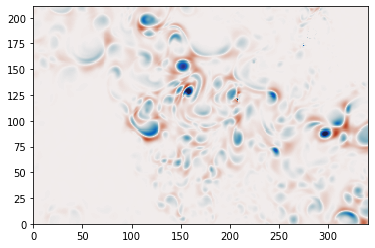

In [22]:
# Let's have a look at the fields
plt.pcolormesh(data_int['OW'].isel(time=0), vmin=-0.05, vmax=0.05, cmap=cm.balance)

We see several eddy-like features that have a low OW-parameter, now let's see whether the algorithm detects them as eddies!

### DETECTION

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be in the range (-180, 180). `'lon2'` can be smaller than `'lon1'` if you want to extract work in a region extending across the dateline (e.g. `'lon1': 160`, `'lon2': -170`). 
Additionally `'lon1'` needs to be at least 2 degrees smaller than in the `interpolation_parameters`, `'lon2'` at least 2 degrees larger, `'lat1'` at least 1 degree smaller and `'lat2'` at least 1 degree larger!  
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [23]:
# Specify parameters for eddy detection
detection_parameters = {'start_time': '2018-01-01', # time range start
                        'end_time': '2018-12-31', # time range end
                        'lon1': 140, # minimum longitude of detection region
                        'lon2': 170, # maximum longitude
                        'lat1': -60, # minimum latitude
                        'lat2': -50, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int['OW_std'].values, # 
                        'OW_thr_name': 'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 20, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 500} # maximum number of pixels (grid cells)

In [24]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect(data_int.isel(z=9), detection_parameters, 'OW', 'vort')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73


In [25]:
# In this format, information for every detected eddy is stored
# (eddies[t][ed], where t is the time step and ed the eddy number)
eddies[0][10]

{'time': numpy.datetime64('2018-01-03T12:00:00.000000000'),
 'type': 'cyclonic',
 'vort_extr': array([-0.02697691], dtype=float32),
 'amp': array([0.07751893], dtype=float32),
 'lon': array([155.91764178]),
 'lat': array([-59.05649363]),
 'eddy_j': array([10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16,
        16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23]),
 'eddy_i': array([154, 155, 153, 154, 155, 156, 153, 154, 155, 156, 157, 152, 153,
        154, 155, 156, 157, 158, 152, 153, 154, 155, 156, 157, 158,

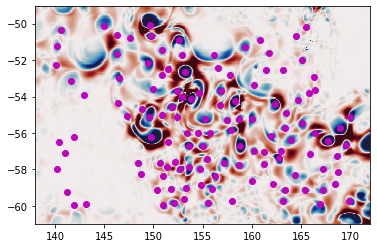

In [26]:
# Plot a single time step to see what the detection method detected
plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.OW.isel(time=0).values,
               vmin=-0.01, vmax=0.01, cmap=cm.balance)

for i in np.arange(0, len(eddies[0])-1):
    if eddies[0][i]['lon'] < 0:
        eddy_lon = eddies[0][i]['lon'] + 360
    else:
        eddy_lon = eddies[0][i]['lon']
    plt.plot(eddy_lon, eddies[0][i]['lat'], marker='o', color='m')

We see that all features below a certain OW threshold have been detected. Some of them, we might not consider as an eddy. If you have the feeling, that two many features are detected, that are not eddies, change parameters like `OW_thr_factor`, `Npix_min`, `Npix_max`

In [27]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies/'
          + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d_'
          + str(datestring) + '_eddies_OW0.3_140_170.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

### TRACKING

Things to note for the setting of `tracking_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the detected eddies. In our case here, for the year 2018 and a 5-day temporal resolution of the data, this is `'2018-01-03'` (if we had daily data, it would be `'2018-01-01'`).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. If you stored the detected eddies in files and want to track these, set `'dict': 0` and make sure `'data_path'`, `'file_root'` and `'file_spec'` are set accordingly. The method will look for files `datapath + file_root + 'YYYYMMDD' + file_spec + '.pickle'`, the date `'YYYYMMDD'` is automatically calculated from `'start_time'`, `'dt'`, and `'end_time'`. You have to make sure that the stored, detected eddies contain that date in their filename (e.g. as defined in the cell above)!

In [28]:
# Specify parameters for eddy tracking
tracking_parameters = {'start_time': '2018-01-03', # time range start
                        'end_time': '2018-12-31', # time range end
                        'dt': 5, # temporal resolution of the data in days
                        'lon1': 140, # minimum longitude of detection region
                        'lon2': 170, # maximum longitude
                        'lat1': -60, # minimum latitude
                        'lat2': -50, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + '/', # path to the detected eddies pickle files
                       'file_root': 'eddies/1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d',
                       'file_spec': 'eddies_OW0.3_140_170',
                       'ross_path': datapath} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [29]:
# Now we track the eddies, all information needed has to be added to `tracking_parameters`
tracks = et.tracking.track(tracking_parameters, in_file=True)

tracking at time step  9  of  73
tracking at time step  17  of  73
tracking at time step  25  of  73
tracking at time step  33  of  73
tracking at time step  42  of  73
tracking at time step  50  of  73
tracking at time step  58  of  73
tracking at time step  66  of  73


We now have tracked all eddies that met the criteria specified in `tracking_parameters`. Every entry `i` in `tracks[i]` corresponds to one complete track.

In [30]:
# The entries in `track` look like this
tracks[4]

{'time': array(['2018-01-03T12:00:00.000000000', '2018-01-08T12:00:00.000000000',
        '2018-01-13T12:00:00.000000000', '2018-01-18T12:00:00.000000000'],
       dtype='datetime64[ns]'),
 'type': 'anticyclonic',
 'vort_extr': array([0.05312092, 0.03576886, 0.04219742, 0.0512756 ], dtype=float32),
 'amp': array([0.06472572, 0.12199267, 0.07957739, 0.0511419 ], dtype=float32),
 'lon': array([169.90486573, 169.83862475, 169.58630192, 169.62826597]),
 'lat': array([-59.72201543, -59.63163135, -59.2661689 , -59.00747198]),
 'eddy_j': {0: array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7,
         8, 8, 8, 8, 9, 9, 9]),
  1: array([ 2,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11,
         11, 11, 12, 12]),
  2: array([10, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15,
         15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18]),
  3: array([17, 17, 18, 18, 18,

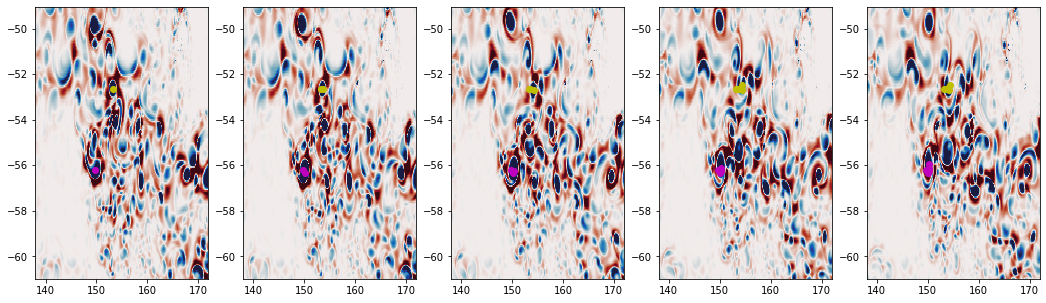

In [31]:
# To have a look at how the tracking performs, just pick too eddies and see whether they are tracked.
ed1 = 48
ed2 = 77
t = 0
j = 5

plt.figure(figsize=(18, j))

plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)

ed1_lon = tracks[ed1]['lon']
ed1_lon[ed1_lon < 0] = ed1_lon[ed1_lon < 0] + 360
ed2_lon = tracks[ed2]['lon']
ed2_lon[ed2_lon < 0] = ed2_lon[ed2_lon < 0] + 360

for i in np.arange(0, j):
    plt.subplot(1, j, i + 1)
    plt.pcolormesh(plot_lon, data_int.lat, data_int.OW.isel(time=t + i).values,
                   vmin=-0.01, vmax=0.01, cmap=cm.balance)
    plt.plot(ed1_lon[t:t + i+1], tracks[ed1]['lat'][t:t + i+1], marker='o', color='m')
    plt.plot(ed2_lon[t:t + i+1], tracks[ed2]['lat'][t:t + i+1], marker='o', color='y')

In [32]:
# We save the tracks for later use
with open(datapath + 'tracks/'
          + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d_20180101_20181231_tracks_OW0.3'
          + '_140_170.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [33]:
# This is how to open the tracks-file again (no need to do that if we just saved it)
with open(datapath + 'tracks/'
          + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d_20180101_20181231_tracks_OW0.3'
          + '_140_170.pickle', 'rb') as f:
    tracks = pickle.load(f)
f.close()

### SAMPLING

Things to note for the setting of `sample_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the tracked eddies. In our case here, for the year 2018 and a 5-day temporal resolution of the data, this is `'2018-01-03'` (if we had daily data, it would be `'2018-01-01'`).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. Right now, the usage of `'range'` and `'split'` has not been thouroughly tested! It seems to work for most cases though.  

`'range'`: Set to `True` if you only want to sample eddies within a certain range `'values_range'` of a property `'var_range'` in the dataset `'ds_range'`. `'var_range'` needs to be 2D (thus the `.isel(z=9)` in the example below) and interpolated to the same grid as `OW` used above. It is most likely that, if you follow this example, `'var_range'` is stored in the same dataset as `OW`. In the example below, only eddies that have a center temperature between 4 and 7 degrees C at depth level 10 (`z=9`) will be sampled and stored.  

`'split'`: Set to `True` if you want to split the sampled eddies into two categories, above and below a certain threshold value `'value_split'` of a variable `'var_split'` in the dataset `'ds_split'`. As for `'range'`, `'var_split'` needs to be 2D and interpolated to the same grid as `OW` used above. In the example below the eddies will be put into two categories: In the first category, the eddies must have a center salinity above 34.0 and in the second category, below 34.0.

In [34]:
# For the sampling we again have to specify some parameters, defining when, where and which 
# eddies to sample.
# Because the dataset containing the sampled eddies can grow huge for larger regions and/or
# longer time periods, `eddytools.sample.sample()` writes the samples for each individual
# eddy to individual netcdf-files on disk!
sample_parameters = {'start_time': '2018-01-03', # time range start
                    'end_time': '2018-12-31', # time range end
                    'max_time': 146, # maximum length of tracks to consider
                                     # (model time steps)
                    'lon1': 140, # minimum longitude of detection region
                    'lon2': 170, # maximum longitude
                    'lat1': -60, # minimum latitude
                    'lat2': -50, # maximum latitude
                    'type': 'anticyclonic', # type of eddy
                    'lifetime': 20, # length of the eddy's track in days
                    'size': 20, # eddy size (diameter in km)
                    'range': False, # sample eddy within a range of `var_range`
                    'ds_range': data_int.isel(z=9), # dataset of `var_range`
                    'var_range': ['votemper'], # variable to base the range on
                    'value_range': [[4, 7],], # range of `var_range`
                    'split': False, # split eddies at a threshold in below and above
                    'ds_split': data_int.isel(z=9), # dataset of `var_split`
                    'var_split': ['vosaline'], # variable to base split on
                    'value_split': [34.0,], # split eddies at this value
                    'sample_vars': ['votemper'], # variables to sample
                    'save_location': datapath + 'samples/', # where to store the netcdf files 
                    'save_name': '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d_140_170'}

The sampling can take quite long as for every eddy that fits the criteria we need to read data from disk at every time step  
The names of the files will be defined by `save_name`, the criteria you specify and the eddy number  
For this sampling parameters, the file name of the first eddy will be  
`1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d.cyclonic.larger_25.longer_5.0000001.nc`  

If you set `'split'` to `True`, the file names will differ for the two categories.  
`1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d.cyclonic.larger_25.longer_5.0000001.above_thr.nc` for eddies that are above `'value_split'`  
`1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d.cyclonic.larger_25.longer_5.0000001.below_thr.nc`
for eddies that are below `'value_split'`.

In [35]:
et.sample.sample(tracks, data_int, sample_parameters)

data prepared, now sampling
sampling eddy number 0 of 1393
sampling eddy number 155 of 1393
sampling eddy number 310 of 1393
sampling eddy number 464 of 1393
sampling eddy number 619 of 1393
sampling eddy number 774 of 1393
sampling eddy number 929 of 1393
sampling eddy number 1083 of 1393
sampling eddy number 1238 of 1393


# AVERAGING

We can now average over the sampled eddies.  
As each eddy has its own file, we first need to find out how many files/samples there are, so we can loop over them and then store the datasets in a dictionary.  
Note that for large region, i.e. a lot of samples the resulting dataset could be too large to fit into memory. The `chunks={}` argument to `xr.open_dataset()` is an attempt to overcome this, however I do not know yet whether this has a lot of effect! One could also split the samples into several parts and then work on each part seperately (the number of eddies going into each average is stored, so one could later do a weighted average over the different parts!)

In [36]:
# Find out number of samples
samples = {}
num_samples = len(glob(sample_parameters['save_location']
                       + sample_parameters['save_name'] + '.anticyclonic.larger_20.longer_20.*.nc'))

In [37]:
# Now we load each stored sample
for i in np.arange(1, num_samples + 1):
    snum = "%07d" % (i,)
    samples[i] = xr.open_dataset(sample_parameters['save_location'] + sample_parameters['save_name'] +
                                 '.anticyclonic.larger_20.longer_20.' + str(snum) + '.nc', chunks={})

First a "preparation" is performed: Basically, all eddies are interpolated onto a normalized (in length) section crossing them zonally through the eddy center.  
For every variable specified, at every time step, the values and anomalies (with respect to surroundings) are interpolated onto the normalized section and stored according to the month the eddy was first detected. The depth profile of the surroundings is stored as well.

In [38]:
normalized_eddies = et.average.prepare(samples, ['votemper'])

votemper


In [39]:
normalized_eddies['votemper_anom']['12'].shape

(5, 49, 46, 101)

Here for example, 5 eddies originating in December have been stored with a maximum length of 49 time steps. 46 is the length of the depth dimension, 101 the length of the normalized section (-0.5, 0.5, 0.01)

Next we can average these samples in different ways.  
Three possibilities are given with `average`  
1. seasonal -> bins the samples (of all available years) into four seasons (DJF, MAM, JJA, SON) and averages them into a seasonal climatology  
2. monthly  -> does the same for each month (so you end up with a monthly climatology)  
3. total    -> averages over all available eddies  
The three methods all return the means, standard deviations (across eddies), and the number of eddies that went into the derived quantities for a) the variables specified, b) their anomalies to the surroundings, c) the surroundings. These results are stored in the output dictionary under `output['ave']['mean'][period]['variable']`, `output['ave']['mean'][period]['variable_anom']`, `output['ave']['mean'][period]['variable_around']`, respectively. `period` refers to 1. `DJF`, `MAM`, `JJA` or `SON`, 2. `01`, `02`, `03`, etc., representing the month, or in case of the total average thie layer in the dictionary does not exist.  
Additionally, the averaged temporal evolution of the eddy centers will be stored under `output['evo'][...]`.

In [40]:
season_eddies = et.average.seasonal(normalized_eddies, ['votemper'])

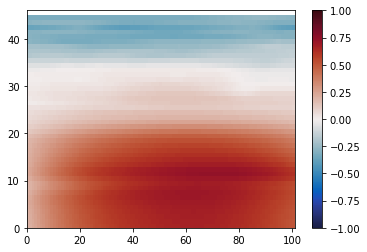

In [41]:
plt.pcolormesh(season_eddies['ave']['mean']['DJF']['votemper_anom'], vmin=-1, vmax=1, cmap=cm.balance)
plt.colorbar()

In [42]:
monthly_eddies = et.average.monthly(normalized_eddies, ['votemper'])

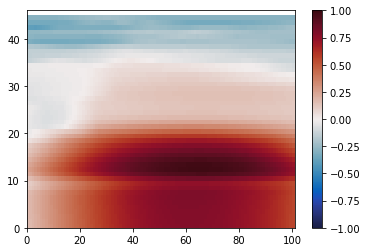

In [43]:
plt.pcolormesh(monthly_eddies['ave']['mean']['03']['votemper_anom'], vmin=-1, vmax=1, cmap=cm.balance)
plt.colorbar()

In [44]:
total_eddies = et.average.total(normalized_eddies, ['votemper'])

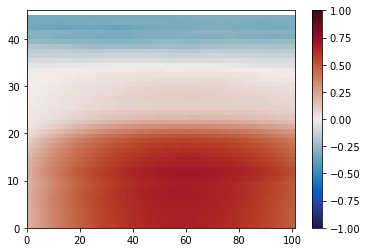

In [45]:
plt.pcolormesh(total_eddies['ave']['mean']['votemper_anom'], vmin=-1, vmax=1, cmap=cm.balance)
plt.colorbar()